# Setting Up

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import networkx as nx

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

In [3]:
import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/assets/global.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

In [4]:
DIRNAME = '15min_MERIT-Plus_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.25
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}

# Load Watershed Attributes

In [5]:
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_attributes_graph

,huc_02,gauge_lon,gauge_lat,area_geospa_fabric,snapped_lon,snapped_lat,snapped_uparea,snapped_iou,area_percent_difference,num_nodes,num_edges
gauge_id,,,,,,,,,,,
06452000,10,-99.55649,43.74833,25817.78,-99.625,43.625,24768.4,0.770155,4.064559,44.0,43.0
13340000,17,-116.25750,46.47833,14270.76,-116.125,46.375,15034.6,0.786640,5.352482,28.0,27.0
06447000,10,-101.52487,43.75250,12869.46,-101.625,43.625,11850.4,0.760950,7.918433,21.0,20.0
06360500,10,-100.84292,45.25582,12601.47,-100.875,45.375,13081.6,0.766271,3.810110,24.0,23.0
06354000,10,-100.93444,46.37611,10626.74,-100.875,46.375,12839.5,0.703405,20.822563,24.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
14303200,17,-123.54650,45.32428,8.07,-123.625,45.375,543.9,0.014827,6639.777300,1.0,0.0
10336740,16,-119.93546,39.06658,7.94,-119.875,39.125,600.6,0.013223,7464.231000,1.0,0.0
01466500,02,-74.50528,39.88500,6.25,-74.375,39.875,594.2,0.008835,9407.200000,1.0,0.0


In [6]:
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
print(camels_graph.shape)
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(camels_graph.shape)
# Print the number of graphs per 'huc_02' (sorted in values of huc_02)
camels_graph.sort_values(ascending=True, by = 'huc_02').groupby('huc_02').size()
# camels_graph['huc_02'].value_counts(sort=True)

(86, 11)
(61, 11)


huc_02
01     2
02     3
03     8
04     4
05     3
06     1
07     5
08     1
09     4
10    10
11     6
12     1
13     1
15     2
16     2
17     7
18     1
dtype: int64

In [7]:
camels_graph['area_geospa_fabric'].describe()

count       61.000000
mean      3421.392295
std       4027.699501
min        995.650000
25%       1292.620000
50%       2076.550000
75%       3371.380000
max      25817.780000
Name: area_geospa_fabric, dtype: float64

In [8]:
del camels_attributes_graph

# Create Node Features as csv

In [9]:
os.makedirs(os.path.join(SAVE_PATH, "graph_features"), exist_ok = True)

In [10]:
ldd = xr.open_dataset(os.path.join(PATHS['gis_ldd'], 'MERIT-Plus_15min', 'ldd.nc'))
ldd = ldd['ldd']
ldd = ldd.sel(
    lat = slice(region_bounds['maxy'], region_bounds['miny']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)

lons = ldd['lon'].values
lats = ldd['lat'].values

ds_grid = xr.Dataset({
    'lat': (['lat'], lats),
    'lon': (['lon'], lons),
})

# Round the lat lon values to 3 decimal places in ds_grid
ds_grid['lat'] = ds_grid['lat'].round(3)
ds_grid['lon'] = ds_grid['lon'].round(3)

## ERA5

### Dynamic

In [10]:
var_names = [
    # '2m_temperature', 
    # 'evaporation', 
    # 'snowfall', 
    # 'surface_net_solar_radiation', 
    # 'surface_net_thermal_radiation', 
    # 'surface_pressure', 
    # 'total_precipitation',
    # '2m_dewpoint_temperature',
    # '10m_u_component_of_wind',
    # '10m_v_component_of_wind',
    # 'forecast_albedo',
    # 'potential_evaporation',
    # 'runoff',
    # 'snow_albedo',
    # 'snow_depth',
    # 'snowmelt',
    # 'sub_surface_runoff',
    # 'surface_runoff',
    # 'total_column_water',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3',
    'volumetric_soil_water_layer_4'
]

dates = pd.date_range('1980-01-01', '2020-12-31', freq='D')
dates = dates[~((dates.month == 2) & (dates.day == 29))]
print(f"Number of dates: {len(dates)}")

def process(idx, row, var_name):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
    data = pd.DataFrame(index = dates, columns = nodes_coords.index)
    os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic'), exist_ok = True)
    os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ERA5'), exist_ok = True)
    data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ERA5', f"{var_name}.csv"))

for var_name in var_names:
    print(var_name)
    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row, var_name) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

Number of dates: 14965
volumetric_soil_water_layer_1


100%|██████████| 61/61 [00:00<00:00, 70.53it/s]


volumetric_soil_water_layer_2


100%|██████████| 61/61 [00:00<00:00, 348.76it/s]


volumetric_soil_water_layer_3


100%|██████████| 61/61 [00:00<00:00, 412.15it/s]


volumetric_soil_water_layer_4


100%|██████████| 61/61 [00:00<00:00, 369.02it/s]


In [11]:
for var_name in itertools.islice(var_names, 0, None, 1):
    print(var_name)
    ds = xr.open_mfdataset(os.path.join(PATHS['RawData'], 'ERA5', var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
    ds['lon'] = [lon_360_180(lon) for lon in ds['lon'].values]
    ds = ds.sortby('lon')
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    _, index = np.unique(ds['time'], return_index = True)
    ds = ds.isel(time = index)

    if os.path.exists(os.path.join(PATHS['Assets'], 'regridder_era5_to_merit-plus_15min.nc')):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = os.path.join(PATHS['Assets'], 'regridder_era5_to_merit-plus_15min.nc')
        )
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False
        )
        regridder.to_netcdf(os.path.join(PATHS['Assets'], 'regridder_era5_to_merit-plus_15min.nc'))
    
    ds_regrided = regridder(ds)
    ds.close()
    start_time = time.time()
    ds_regrided.load()
    end_time = time.time()
    print(f'Time: {((end_time - start_time) / 60):.4f} mins')
    
    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ERA5', f"{var_name}.csv"), index_col = 0, parse_dates = True)
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            ds_window_loc = ds_regrided.sel(lat = lat, lon = lon, method = 'nearest')
            data.loc[:, str(node_idx)] = ds_window_loc.values
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ERA5', f"{var_name}.csv"))

    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

    ds.close()
    del ds
    gc.collect()

volumetric_soil_water_layer_1
Time: 4.5017 mins


100%|██████████| 61/61 [00:04<00:00, 15.24it/s]


volumetric_soil_water_layer_2
Time: 4.4641 mins


100%|██████████| 61/61 [00:02<00:00, 21.34it/s]


volumetric_soil_water_layer_3
Time: 4.4752 mins


100%|██████████| 61/61 [00:03<00:00, 19.08it/s]


volumetric_soil_water_layer_4
Time: 4.5655 mins


100%|██████████| 61/61 [00:03<00:00, 20.20it/s]


### Static

In [16]:
var_names = [
    'static_soil_type', 
    'static_high_vegetation_cover', 
    'static_low_vegetation_cover', 
    'static_type_of_high_vegetation', 
    'static_type_of_low_vegetation'
    ]
ds_filenames = [
    'soil_type_static.nc',
    'high_vegetation_cover_static.nc',
    'low_vegetation_cover_static.nc',
    'type_of_high_vegetation_static.nc',
    'type_of_low_vegetation_static.nc'
]

for var_name, ds_filename in zip(var_names, ds_filenames):
    print(var_name)
    ds = xr.open_dataset(os.path.join(PATHS['RawData'], 'ERA5', ds_filename))
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.isel(time = 0)
    ds = ds.drop('time')
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    ds['lon'] = [lon_360_180(lon) for lon in ds['lon'].values]
    ds = ds.sortby('lon')
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(columns = nodes_coords.index, index = [0])
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            ds_window_loc = ds.sel(lat = lat, lon = lon, method = 'nearest')
            data.loc[0, node_idx] = int(ds_window_loc.values)
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static'), exist_ok = True)
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'ERA5'), exist_ok = True)
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'ERA5', f"{var_name}.csv"))

    for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)):
        process(idx, row)

static_soil_type


100%|██████████| 61/61 [00:00<00:00, 112.20it/s]


static_high_vegetation_cover


100%|██████████| 61/61 [00:00<00:00, 123.69it/s]


static_low_vegetation_cover


100%|██████████| 61/61 [00:00<00:00, 123.04it/s]


static_type_of_high_vegetation


100%|██████████| 61/61 [00:00<00:00, 123.91it/s]


static_type_of_low_vegetation


100%|██████████| 61/61 [00:00<00:00, 123.86it/s]


## HWSD

In [13]:
var_names = ['S_CLAY', 'S_GRAVEL', 'S_SAND', 'S_SILT', 'T_CLAY', 'T_GRAVEL', 'T_SAND', 'T_SILT']

for var_name in var_names:
    print(var_name)
    ds = xr.open_dataset(os.path.join(PATHS['HWSD'], f'{var_name}.nc4'))
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(
        lat = slice(region_bounds['miny'], region_bounds['maxy']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    ds = ds / 100
    ds.load()
    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(columns = nodes_coords.index, index = [0])
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            ds_window_loc = ds.sel(
                lat = slice(lat-resolution/2, lat+resolution/2),
                lon = slice(lon-resolution/2, lon+resolution/2)
            ).values.mean()
            data.loc[0, node_idx] = ds_window_loc
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static'), exist_ok = True)
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'HWSD'), exist_ok = True)
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'HWSD', f"{var_name}.csv"))

    for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)):
        process(idx, row)
    
    ds.close()
    del ds
    gc.collect()

S_CLAY


100%|██████████| 61/61 [00:00<00:00, 229.07it/s]


S_GRAVEL


100%|██████████| 61/61 [00:00<00:00, 248.27it/s]


S_SAND


100%|██████████| 61/61 [00:00<00:00, 248.13it/s]


S_SILT


100%|██████████| 61/61 [00:00<00:00, 248.86it/s]


T_CLAY


100%|██████████| 61/61 [00:00<00:00, 248.21it/s]


T_GRAVEL


100%|██████████| 61/61 [00:00<00:00, 242.63it/s]


T_SAND


100%|██████████| 61/61 [00:00<00:00, 246.06it/s]


T_SILT


100%|██████████| 61/61 [00:00<00:00, 248.25it/s]


## GLEAM

In [10]:
var_names = ['Ep', 'SMroot', 'SMsurf']

dates = pd.date_range('1980-01-01', '2020-12-31', freq='D')
dates = dates[~((dates.month == 2) & (dates.day == 29))]
print(f"Number of dates: {len(dates)}")

def process(idx, row, var_name):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
    data = pd.DataFrame(index = dates, columns = nodes_coords.index)
    os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic'), exist_ok = True)
    os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM'), exist_ok = True)
    data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"))

for var_name in var_names:
    print(var_name)
    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row, var_name) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

Number of dates: 14965
Ep


100%|██████████| 61/61 [00:00<00:00, 86.02it/s]


SMroot


100%|██████████| 61/61 [00:00<00:00, 377.83it/s]


SMsurf


100%|██████████| 61/61 [00:00<00:00, 379.05it/s]


In [11]:
for var_name in itertools.islice(var_names, 0, None, 1):
    print(var_name)
    ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )

    if os.path.exists(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')
        )
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False
        )
        regridder.to_netcdf(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc'))
    
    ds_regrided = regridder(ds)
    ds.close()
    start_time = time.time()
    ds_regrided.load()
    end_time = time.time()
    print(f'Time: {((end_time - start_time) / 60):.4f} mins')
    
    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"), index_col = 0, parse_dates = True)
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            ds_window_loc = ds_regrided.sel(lat = lat, lon = lon, method = 'nearest')
            data.loc[:, str(node_idx)] = ds_window_loc.values
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"))

    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

    ds.close()
    del ds
    gc.collect()

Ep
Time: 1.0011 mins


100%|██████████| 61/61 [00:03<00:00, 20.08it/s]


SMroot
Time: 0.9524 mins


100%|██████████| 61/61 [00:03<00:00, 19.06it/s]


SMsurf
Time: 0.9237 mins


100%|██████████| 61/61 [00:03<00:00, 18.99it/s]


### Fix NaNs

In [ ]:
var_names = ['Ep', 'SMroot', 'SMsurf']
for var_name in var_names:
    ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    if os.path.exists(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')
        )
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False
        )
        regridder.to_netcdf(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc'))
    ds_regrided = regridder(ds)
    ds.close()
    start_time = time.time()
    ds_regrided.load()
    end_time = time.time()
    print(f'{var_name} (Time: {((end_time - start_time) / 60):.4f} mins)')

    # Loop over catchments and find ones with issues
    issues = []
    for idx, row in tqdm.tqdm(camels_graph.iterrows()):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"), index_col = 0, parse_dates = True)
        if data.isnull().values.any():
            issues.append([huc, gauge_id])
    issues = pd.DataFrame(issues, columns = ['huc_02', 'gauge_id'])
    print(f"Number of catchments with issues: {issues.shape[0]}")
    print("------")

    # Fix the catchments with issues
    for issue_idx, (huc, gauge_id) in enumerate(issues.values):
        print(issue_idx, huc, gauge_id)
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"), index_col = 0, parse_dates = True)
        nodes_coords['isNaN'] = False
        nodes_coords['nonNaNneighbours'] = 0
        # Loop over nodes and find the nodes with issues
        for node_idx in nodes_coords.index:
            if data[str(node_idx)].isnull().values.any():
                nodes_coords.loc[node_idx, 'isNaN'] = True
                node_lat = float(round(nodes_coords.loc[node_idx, 'lat'], 3))
                node_lon = float(round(nodes_coords.loc[node_idx, 'lon'], 3))
                multiplier = 1.5
                ds_slice = ds_regrided.sel(
                    lat = slice(node_lat+multiplier*resolution, node_lat-multiplier*resolution), 
                    lon = slice(node_lon-multiplier*resolution, node_lon+multiplier*resolution)
                    )
                slice_df = ds_slice.to_dataframe(name = var_name).reset_index()
                slice_df['lat'] = slice_df['lat'].round(3)
                slice_df['lon'] = slice_df['lon'].round(3)
                slice_df['location'] = list(zip(slice_df['lat'], slice_df['lon']))
                slice_df = slice_df.pivot(index='time', columns='location', values=var_name)
                num_nan_nodes = slice_df.isnull().any(axis=0).sum()
                num_nonnan_nodes = len(slice_df.columns) - num_nan_nodes
                nodes_coords.loc[node_idx, 'nonNaNneighbours'] = num_nonnan_nodes
        nodes_coords_sorted = nodes_coords.sort_values(by = 'nonNaNneighbours', ascending = False)
        nodes_coords_sorted = nodes_coords_sorted[nodes_coords_sorted['isNaN']]
        print(f"Number of nodes with NaN values: {nodes_coords_sorted.shape[0]}")
        
        for node_idx in tqdm.tqdm(nodes_coords_sorted.index):
            node_lat, node_lon = float(round(nodes_coords.loc[node_idx, 'lat'], 3)), float(round(nodes_coords.loc[node_idx, 'lon'], 3))
            multiplier = 1.5
            ds_slice = ds_regrided.sel(
                lat = slice(node_lat+multiplier*resolution, node_lat-multiplier*resolution), 
                lon = slice(node_lon-multiplier*resolution, node_lon+multiplier*resolution)
                )
            slice_df = ds_slice.to_dataframe(name = var_name).reset_index()
            slice_df['lat'] = slice_df['lat'].round(3)
            slice_df['lon'] = slice_df['lon'].round(3)
            slice_df['location'] = list(zip(slice_df['lat'], slice_df['lon']))
            slice_df = slice_df.pivot(index='time', columns='location', values=var_name)
            slice_df.columns = list(map(str, slice_df.columns))
            num_nonnan_nodes = len(slice_df.columns) - slice_df.isnull().any(axis=0).sum()
            # print(node_idx, (node_lat, node_lon), num_nonnan_nodes)
            if num_nonnan_nodes == 9:
                replacement_values = slice_df.loc[:, f"({node_lat}, {node_lon})"]
                data.loc[:, str(node_idx)] = replacement_values
                nodes_coords_sorted.loc[node_idx, 'isNaN'] = False
            elif num_nonnan_nodes > 0:
                replacement_values = np.nanmean(slice_df, axis = 1)
                data.loc[:, str(node_idx)] = replacement_values
                ds_regrided.loc[dict(lat = node_lat, lon = node_lon)] = replacement_values
                nodes_coords_sorted.loc[node_idx, 'isNaN'] = False
        print(f"Number of nodes with NaN values: {nodes_coords_sorted['isNaN'].sum()}")
        print(issue_idx, huc, gauge_id, data.isnull().values.any())
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"))
        print("------")

Time: 0.8668 mins


61it [00:01, 31.02it/s]


Number of catchments with issues: 3
------
0 10 06191500
Number of nodes with NaN values: 3


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


Number of nodes with NaN values: 0
0 10 06191500 False
------
1 04 04045500
Number of nodes with NaN values: 1


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Number of nodes with NaN values: 0
1 04 04045500 False
------
2 03 02196000
Number of nodes with NaN values: 1


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]

Number of nodes with NaN values: 0
2 03 02196000 False
------


Time: 0.8757 mins


61it [00:02, 29.62it/s]


Number of catchments with issues: 3
------
0 10 06191500
Number of nodes with NaN values: 3


100%|██████████| 3/3 [00:00<00:00,  9.50it/s]


Number of nodes with NaN values: 0
0 10 06191500 False
------
1 04 04045500
Number of nodes with NaN values: 1


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


Number of nodes with NaN values: 0
1 04 04045500 False
------
2 03 02196000
Number of nodes with NaN values: 1


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

Number of nodes with NaN values: 0
2 03 02196000 False
------


### Development

In [12]:
var_name = 'Ep'
ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], var_name, f"*.nc"), combine='by_coords')
ds_var_name = list(ds.data_vars)[0]
ds = ds[ds_var_name]
ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
ds = ds.sel(
    lat = slice(region_bounds['maxy'], region_bounds['miny']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)
if os.path.exists(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')):
    regridder = xe.Regridder(
        ds, 
        ds_grid, 
        'bilinear', 
        reuse_weights=True, 
        filename = os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc')
    )
else:
    regridder = xe.Regridder(
        ds, 
        ds_grid, 
        'bilinear', 
        reuse_weights=False
    )
    regridder.to_netcdf(os.path.join(PATHS['Assets'], 'regridder_gleam_to_merit-plus_15min.nc'))
ds_regrided = regridder(ds)
ds.close()
start_time = time.time()
ds_regrided.load()
end_time = time.time()
print(f'Time: {((end_time - start_time) / 60):.4f} mins')

Time: 0.9592 mins


In [13]:
# Loop over catchments and find ones with issues
issues = []
for idx, row in tqdm.tqdm(camels_graph.iterrows()):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
    data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"), index_col = 0, parse_dates = True)
    # if any NaNs in data, append [huc, gauge_id] to issues
    if data.isnull().values.any():
        issues.append([huc, gauge_id])

61it [00:02, 20.86it/s]


In [14]:
issues_df = pd.DataFrame(issues, columns = ['huc_02', 'gauge_id'])
issues_df

,huc_02,gauge_id
0,10,06191500
1,04,04045500
2,03,02196000


In [31]:
huc, gauge_id = issues_df.iloc[2]
print(huc, gauge_id)
nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
data = pd.read_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GLEAM', f"{var_name}.csv"), index_col = 0, parse_dates = True)
nodes_coords['isNaN'] = False
nodes_coords['nonNaNneighbours'] = 0

03 02196000


In [32]:
nodes_coords

,lon,lat,isNaN,nonNaNneighbours
0,-82.125,33.875,False,0
1,-81.875,33.875,False,0


In [33]:
# Loop over nodes and find the nodes with issues
for node_idx in nodes_coords.index:
    if data[str(node_idx)].isnull().values.any():
        nodes_coords.loc[node_idx, 'isNaN'] = True
print(f"Number of nodes with NaN values: {nodes_coords['isNaN'].sum()}")

Number of nodes with NaN values: 1


In [34]:
# Loop over nodes with issues and find the number of non-NaN neighbours
for node_idx in nodes_coords[nodes_coords['isNaN']].index:
    node_lat, node_lon = round(nodes_coords.loc[node_idx, 'lat'], 3), round(nodes_coords.loc[node_idx, 'lon'], 3)
    multiplier = 1.5
    ds_slice = ds_regrided.sel(
        lat = slice(node_lat+multiplier*resolution, node_lat-multiplier*resolution), 
        lon = slice(node_lon-multiplier*resolution, node_lon+multiplier*resolution)
        )
    slice_df = ds_slice.to_dataframe(name = var_name).reset_index()
    slice_df['lat'] = slice_df['lat'].round(3)
    slice_df['lon'] = slice_df['lon'].round(3)
    slice_df['location'] = list(zip(slice_df['lat'], slice_df['lon']))
    slice_df = slice_df.pivot(index='time', columns='location', values=var_name)
    num_nan_nodes = slice_df.isnull().any(axis=0).sum()
    num_nonnan_nodes = len(slice_df.columns) - num_nan_nodes
    nodes_coords.loc[node_idx, 'nonNaNneighbours'] = num_nonnan_nodes

In [35]:
nodes_coords_sorted = nodes_coords.sort_values(by = 'nonNaNneighbours', ascending = False)
nodes_coords_sorted = nodes_coords_sorted[nodes_coords_sorted['isNaN']]
nodes_coords_sorted

,lon,lat,isNaN,nonNaNneighbours
1,-81.875,33.875,True,5


In [37]:
for node_idx in nodes_coords_sorted.index:
    node_lat, node_lon = float(round(nodes_coords.loc[node_idx, 'lat'], 3)), float(round(nodes_coords.loc[node_idx, 'lon'], 3))
    multiplier = 1.5
    ds_slice = ds_regrided.sel(
        lat = slice(node_lat+multiplier*resolution, node_lat-multiplier*resolution), 
        lon = slice(node_lon-multiplier*resolution, node_lon+multiplier*resolution)
        )
    slice_df = ds_slice.to_dataframe(name = var_name).reset_index()
    slice_df['lat'] = slice_df['lat'].round(3)
    slice_df['lon'] = slice_df['lon'].round(3)
    slice_df['location'] = list(zip(slice_df['lat'], slice_df['lon']))
    slice_df = slice_df.pivot(index='time', columns='location', values=var_name)
    slice_df.columns = list(map(str, slice_df.columns))
    num_nonnan_nodes = len(slice_df.columns) - slice_df.isnull().any(axis=0).sum()
    print(node_idx, (node_lat, node_lon), num_nonnan_nodes)
    if num_nonnan_nodes == 9:
        replacement_values = slice_df.loc[:, f"({node_lat}, {node_lon})"]
        data.loc[:, str(node_idx)] = replacement_values
        nodes_coords_sorted.loc[node_idx, 'isNaN'] = False
    elif num_nonnan_nodes > 0:
        replacement_values = np.nanmean(slice_df, axis = 1)
        data.loc[:, str(node_idx)] = replacement_values
        ds_regrided.loc[dict(lat = node_lat, lon = node_lon)] = replacement_values
        nodes_coords_sorted.loc[node_idx, 'isNaN'] = False

1 (33.875, -81.875) 6


## Solar Insolation

In [14]:
def solar_insolation(lat, lon, start_date, end_date):
    # Constants
    Sc = 1361  # Solar constant (W/m^2)
    
    # Convert dates to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = dates[~((dates.month == 2) & (dates.day == 29))]
    
    # Function to calculate solar declination
    def solar_declination(n):
        return 23.45 * np.sin(np.radians((360 / 365) * (n - 81)))

    # Function to calculate cos(theta_z) for solar zenith angle
    def cos_theta_z(lat, decl, hour_angle):
        lat_rad = np.radians(lat)
        decl_rad = np.radians(decl)
        return (np.sin(lat_rad) * np.sin(decl_rad) + 
                np.cos(lat_rad) * np.cos(decl_rad) * np.cos(np.radians(hour_angle)))
    
    # Function to calculate the hour angle
    def hour_angle(lon, date):
        # Assuming solar noon (local solar time = 12 hours)
        return 0  # hour angle at solar noon
    
    # Calculate solar insolation for each day
    insolation_values = []
    for date in dates:
        day_of_year = date.day_of_year
        declination = solar_declination(day_of_year)
        h = hour_angle(lon, date)
        cos_zenith_angle = cos_theta_z(lat, declination, h)
        
        # Insolation formula
        insolation = Sc * (1 + 0.033 * np.cos(np.radians(360 * day_of_year / 365))) * cos_zenith_angle
        
        # Make sure insolation is non-negative
        insolation = max(insolation, 0)
        insolation_values.append(insolation)
    
    # Create pandas Series
    insolation_series = pd.Series(insolation_values, index=dates, name='Solar Insolation (kW/m²)')
    insolation_series = insolation_series / 1000  # Convert to kW/m²
    
    return insolation_series

In [16]:
dates = pd.date_range('1980-01-01', '2020-12-31', freq='D')
dates = dates[~((dates.month == 2) & (dates.day == 29))]

def process(idx, row):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)

    data = pd.DataFrame(columns = nodes_coords.index, index = dates)
    for node_idx, node_row in nodes_coords.iterrows():
        lat, lon = node_row['lat'], node_row['lon']
        ds_window_loc = solar_insolation(lat, lon, '1980-01-01', '2020-12-31')
        data.loc[:, node_idx] = ds_window_loc.values

    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id), exist_ok = True)
    data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, f'solar_insolation.csv'))

with Parallel(n_jobs = 8, verbose = 0) as parallel:
    _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

100%|██████████| 61/61 [00:07<00:00,  7.72it/s]


## Time Encodings

In [17]:
def sine_time_encoding(start_date, end_date):
    # (a) Create a date_range and remove leap days
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = dates[~((dates.month == 2) & (dates.day == 29))]  # Remove February 29 (leap days)
    
    # (b) Create a dataframe with 'month', 'weekofyear', 'dayofyear' columns
    df = pd.DataFrame(index=dates)
    df['month'] = df.index.month
    df['weekofyear'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    
    # (c) Define lambda transformations for sine encoding
    # For day of year (range 1-365), week of year (range 1-52), and month (range 1-12)
    sine_transform = lambda x, max_val: np.sin(2 * np.pi * x / max_val)
    
    # (d) Apply sine transformation and add transformed columns
    df['sine_month'] = df['month'].apply(sine_transform, max_val=12)
    df['sine_weekofyear'] = df['weekofyear'].apply(sine_transform, max_val=52)
    df['sine_dayofyear'] = df['dayofyear'].apply(sine_transform, max_val=365)
    
    # return df[['sine_month', 'sine_weekofyear', 'sine_dayofyear']]
    return df

In [18]:
df_encoded = sine_time_encoding('1980-01-01', '2020-12-31')

def process(idx, row):
    huc, gauge_id = row['huc_02'], row.name

    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id), exist_ok = True)
    df_encoded.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, f'time_encodings.csv'))

# with Parallel(n_jobs = 8, verbose = 0) as parallel:
    # _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)):
    process(idx, row)

100%|██████████| 61/61 [00:06<00:00,  9.34it/s]


## Daymet

In [ ]:
dates = pd.date_range('1980-01-01', '2020-12-31', freq='D')
dates = dates[~((dates.month == 2) & (dates.day == 29))]
print(f"Number of dates: {len(dates)}")
var_names = ['prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp', 'dayl']

def process(idx, row, var_name):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
    data = pd.DataFrame(index = dates, columns = nodes_coords.index)
    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic'), exist_ok = True)
    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet'), exist_ok = True)
    data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet', f"{var_name}.csv"))

for var_name in var_names:
    print(var_name)
    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row, var_name) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

In [ ]:
missing_dates = ['1980-12-31', '1984-12-31', '1988-12-31', '1992-12-31',
               '1996-12-31', '2000-12-31', '2004-12-31', '2008-12-31',
               '2012-12-31', '2016-12-31', '2020-12-31']
missing_dates = [date + 'T12:00:00' for date in missing_dates]
missing_dates = np.array(missing_dates, dtype = 'datetime64')
ds_missing_dates = xr.DataArray(
    np.nan*np.zeros((len(missing_dates), len(lats), len(lons))),
    coords = [missing_dates, lats, lons],
    dims = ['time', 'lat', 'lon']
)

In [ ]:
var_names = ['prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp', 'dayl']
for var_name in itertools.islice(var_names, 0, None, 1):
    print(var_name)
    ds = xr.open_mfdataset(os.path.join(PATHS['Daymet'], var_name, f"*.nc"), combine='by_coords')
    ds = ds[var_name]
    ds = ds.rename({'x': 'lon', 'y': 'lat'})
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )

    if os.path.exists(os.path.join(PATHS['Assets'], 'regridder_daymet_to_merit-plus_15min.nc')):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = os.path.join(PATHS['Assets'], 'regridder_daymet_to_merit-plus_15min.nc')
        )
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False
        )
        regridder.to_netcdf(os.path.join(PATHS['Assets'], 'regridder_daymet_to_merit-plus_15min.nc'))
    
    ds_regrided = regridder(ds)
    # ds_regrided['time'] = ds_regrided['time'].dt.floor('D')
    # ds_regrided['time'] = [np.datetime64(str(date).split('T')[0]) for date in ds_regrided['time'].values]

    # Concatenate missing dates
    ds_regrided = xr.concat([ds_regrided, ds_missing_dates], dim = 'time')
    ds_regrided = ds_regrided.sortby('time')
    ds.close()
    # Print length of time
    print(f"timesteps: {len(ds_regrided['time'])}")

    for start_year in range(1980, 2020+1, 5):
        start_date = f"{start_year}-01-01"
        end_date = f"{min(start_year+4,2020)}-12-31"
        ds_window = ds_regrided.sel(time = slice(start_date, end_date)).copy()
        start_time = time.time()
        ds_window.load()
        end_time = time.time()
        print(start_date, end_date, f"Time: {(end_time - start_time)/60:.2f} mins")
    
        def process(idx, row):
            huc, gauge_id = row['huc_02'], row.name
            nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
            data = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet', f"{var_name}.csv"), index_col = 0, parse_dates = True)
            for node_idx, node_row in nodes_coords.iterrows():
                lat, lon = node_row['lat'], node_row['lon']
                ds_window_loc = ds_window.sel(lat = lat, lon = lon, method = 'nearest')
                data.loc[start_date:end_date, str(node_idx)] = ds_window_loc.values
            data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet', f"{var_name}.csv"))
            return None
        
        with Parallel(n_jobs = 8, verbose = 0) as parallel:
            _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

        ds_window.close()
        del ds_window
        gc.collect()

    ds_regrided.close()
    del ds, ds_regrided
    gc.collect()

prcp
timesteps: 14965


In [ ]:
var_names = ['prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp', 'dayl']
for idx, row in tqdm.tqdm(camels_graph.iterrows()):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
    for var_name in var_names:
        data = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet', f"{var_name}.csv"), index_col = 0, parse_dates = True)
        # Fill the NaN values with a window of 15 days centered around the missing value
        for col in data.columns:
            data[col] = data[col].fillna(data[col].rolling(15, min_periods = 1, center = True).mean())
        data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'dynamic', 'Daymet', f"{var_name}.csv"))

## Terrain Attributes

In [10]:
from shapely.geometry import Polygon
import rioxarray

def coords_to_polygon(lon, lat, resolution):
    half_res = resolution / 2
    return Polygon([
        (round(lon - half_res,3), round(lat - half_res,3)),
        (round(lon - half_res,3), round(lat + half_res,3)),
        (round(lon + half_res,3), round(lat + half_res,3)),
        (round(lon + half_res,3), round(lat - half_res,3))
    ])
def tile_filename_to_coords(filename):
    # format: n/s{dd}e/w{ddd}_elv.tif
    # n/e: positive, s/w: negative
    n_s, lat, e_w, lon = filename[0], int(filename[1:3]), filename[3], int(filename[4:7])
    lat = lat if n_s == 'n' else -lat
    lon = lon if e_w == 'e' else -lon
    return (lon, lat)

In [11]:
import itertools
var_names = ['elv', 'slope_percentage', 'slope_riserun', 'slope_degrees', 'slope_radians', 'aspect', 'curvature', 'planform_curvature', 'profile_curvature', 'upa', 'wth']
# valid_tiles = ['n30w150', 'n30w120', 'n30w090']

issues = []
for var_name in itertools.islice(var_names,0,None,1):
    print(var_name)
    tiles_paths = sorted(glob.glob(os.path.join(PATHS['MERIT-Hydro'], var_name, '**', '*.tif'), recursive=True))
    # tiles_paths = [tile for tile in tiles_paths if os.path.basename(os.path.dirname(tile)).split('_')[-1] in valid_tiles]
    tiles_filenames = [os.path.basename(tile) for tile in tiles_paths]
    tiles_names = [tile.split('_')[0] for tile in tiles_filenames]
    tiles_lower_left_corner = [tile_filename_to_coords(tile) for tile in tiles_filenames]
    tiles_polygons = [Polygon([(lon, lat), (lon + 5, lat), (lon + 5, lat + 5), (lon, lat + 5)]) for lon, lat in tiles_lower_left_corner]

    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(columns = nodes_coords.index, index = ['mean', 'std', '25%', '50%', '75%'])
        cell_polygons = [coords_to_polygon(row['lon'], row['lat'], resolution) for _, row in nodes_coords.iterrows()]
        catmt_polygon = cell_polygons[0]
        for polygon in cell_polygons[1:]:
            catmt_polygon = catmt_polygon.union(polygon)
        intersected_tiles = []
        for tile_polygon, tile_path in zip(tiles_polygons, tiles_paths):
            if tile_polygon.intersects(catmt_polygon):
                intersected_tiles.append(tile_path)
        ds = rioxarray.open_rasterio(intersected_tiles[0])
        for tile in intersected_tiles[1:]:
            ds = ds.combine_first(rioxarray.open_rasterio(tile))
        ds = ds.sel(band=1)
        # Sort the x and y coordinates to be ascending
        ds = ds.sortby('x', ascending=True)
        ds = ds.sortby('y', ascending=True)
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            # ds_node = ds.rio.clip_box(lon - resolution/2, lat - resolution/2, lon + resolution/2, lat + resolution/2)
            ds_node = ds.sel(x = slice(lon - resolution/2, lon + resolution/2), y = slice(lat - resolution/2, lat + resolution/2))
            ds_node = ds_node.where(ds_node != ds.rio.nodata)
            ds_node_values = ds_node.values.flatten()
            mean = np.nanmean(ds_node_values)
            std = np.nanstd(ds_node_values)
            q25 = np.nanquantile(ds_node_values, 0.25)
            q50 = np.nanquantile(ds_node_values, 0.50)
            q75 = np.nanquantile(ds_node_values, 0.75)
            data.loc['mean', node_idx] = mean
            data.loc['std', node_idx] = std
            data.loc['25%', node_idx] = q25
            data.loc['50%', node_idx] = q50
            data.loc['75%', node_idx] = q75
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static'), exist_ok = True)
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'MERIT-Hydro'), exist_ok = True)
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'static', 'MERIT-Hydro', f"{var_name}.csv"))

        ds.close()
        del ds
        gc.collect()

    for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)):
        try:
            process(idx, row)
        except Exception as e:
            issues.append(f"{var_name}-{row['huc_02']}-{row.name}")
            print(f"Error: {var_name}-{row['huc_02']}-{row.name}. {e}")

elv


100%|██████████| 61/61 [01:14<00:00,  1.22s/it]


slope_percentage


100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


slope_riserun


100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


slope_degrees


100%|██████████| 61/61 [00:51<00:00,  1.19it/s]


slope_radians


100%|██████████| 61/61 [00:53<00:00,  1.14it/s]


aspect


100%|██████████| 61/61 [00:57<00:00,  1.06it/s]


curvature


100%|██████████| 61/61 [00:58<00:00,  1.04it/s]


planform_curvature


100%|██████████| 61/61 [00:59<00:00,  1.02it/s]


profile_curvature


100%|██████████| 61/61 [01:02<00:00,  1.02s/it]


upa


100%|██████████| 61/61 [01:31<00:00,  1.50s/it]


wth


100%|██████████| 61/61 [01:23<00:00,  1.37s/it]


In [12]:
len(issues)

0

In [13]:
issues_df = [entry.split('-') for entry in issues]
issues_df = pd.DataFrame(issues_df, columns = ['var_name', 'huc_02', 'gauge_id'])
issues_df

,var_name,huc_02,gauge_id


In [14]:
issues_df[issues_df['var_name'] == 'elv']

,var_name,huc_02,gauge_id


### Reject

In [ ]:
import os
import subprocess
import richdem as rd

def calculate_terrain_attributes(dem_path):
    """
    Calculate terrain attributes from a DEM file using richdem library.

    Parameters
    ----------
    dem_path : str
        Path to the DEM file.

    Returns
    -------
    dict
        Dictionary containing the calculated terrain attributes (described below).
        - slope : dict
            - riserun : numpy.ndarray
                Slope calculated as rise over run.
            - percentage : numpy.ndarray
                Slope calculated as percentage.
            - degrees : numpy.ndarray
                Slope calculated in degrees.
            - radians : numpy.ndarray
                Slope calculated in radians.
        - aspect : numpy.ndarray
            Aspect of the terrain.
        - curvature : dict
            - planform : numpy.ndarray
                Planform curvature of the terrain.
            - profile : numpy.ndarray
                Profile curvature of the terrain.
            - curvature : numpy.ndarray
                Curvature of the terrain.
    """
    dem = rd.LoadGDAL(dem_path)

    # slope_riserun, slope_percentage, slope_degrees, slope_radians, aspect, curvature, planform_curvature, profile_curvature
    slope_percentage = rd.TerrainAttribute(dem, attrib='slope_percentage')
    slope_riserun = rd.TerrainAttribute(dem, attrib='slope_riserun')
    slope_degrees = rd.TerrainAttribute(dem, attrib='slope_degrees')
    slope_radians = rd.TerrainAttribute(dem, attrib='slope_radians')
    aspect = rd.TerrainAttribute(dem, attrib='aspect')
    curvature = rd.TerrainAttribute(dem, attrib='curvature')
    planform_curvature = rd.TerrainAttribute(dem, attrib='planform_curvature')
    profile_curvature = rd.TerrainAttribute(dem, attrib='profile_curvature')
    results = {
        'slope': {
            'riserun': slope_riserun,
            'percentage': slope_percentage,
            'degrees': slope_degrees,
            'radians': slope_radians
        },
        'aspect': aspect,
        'curvature': {
            'planform': planform_curvature,
            'profile': profile_curvature,
            'curvature': curvature
        }
    }

    return results

dem_file = "/home/sarth/rootdir/data/raw/MERIT_Hydro_v1/elv/elv_n00e060/n20e080_elv.tif"
terrain_attributes = calculate_terrain_attributes(dem_file)


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.482454======================= ] (99% - 0.0s - 1 threads)===== ] (98% - 0.0s - 1 threads)

A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.490868======================= ] (99% - 0.0s - 1 threads)

A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.16366======================== ] (99% - 0.0s - 1 threads)

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.89766======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981.

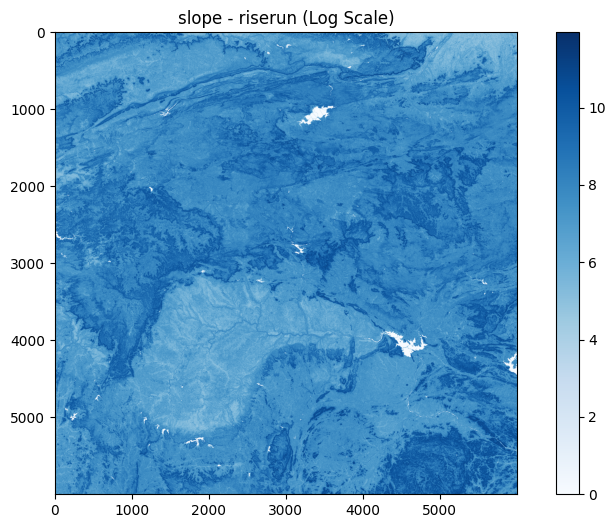

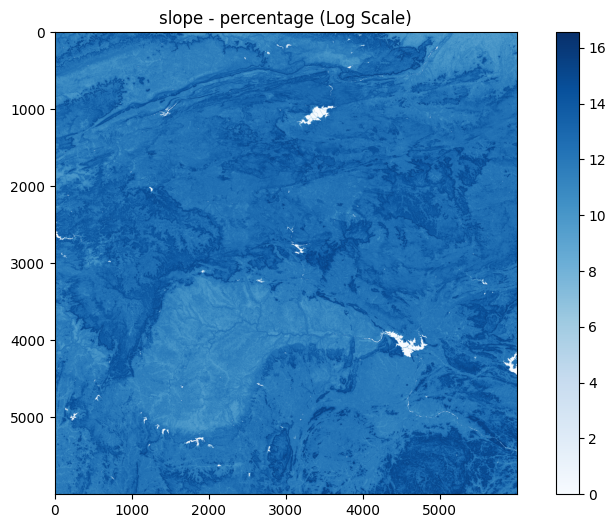

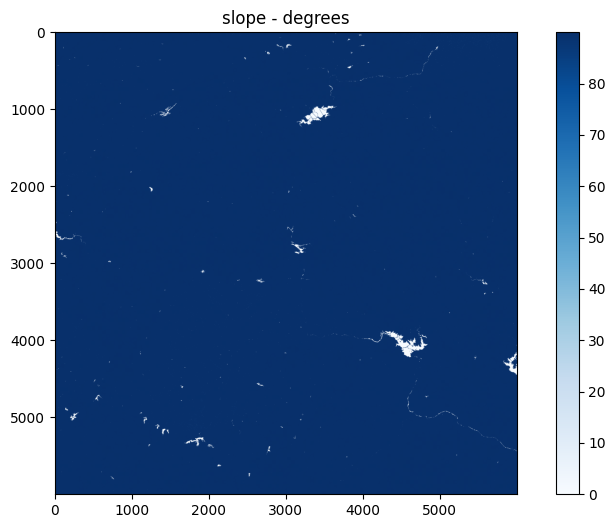

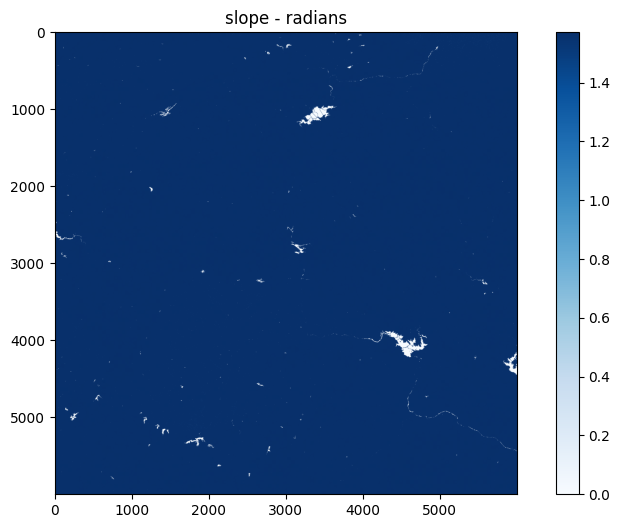

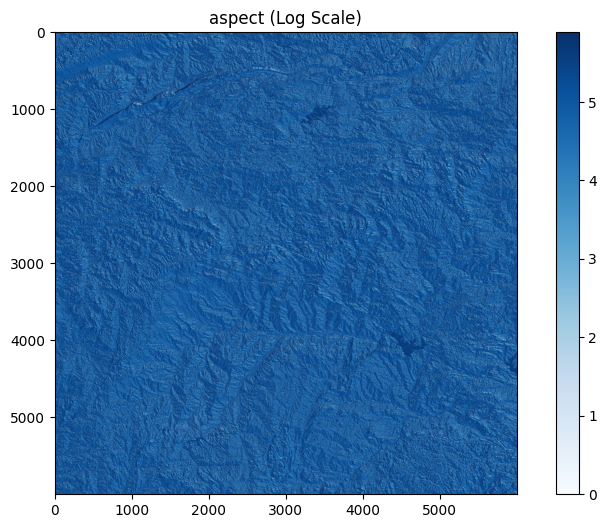

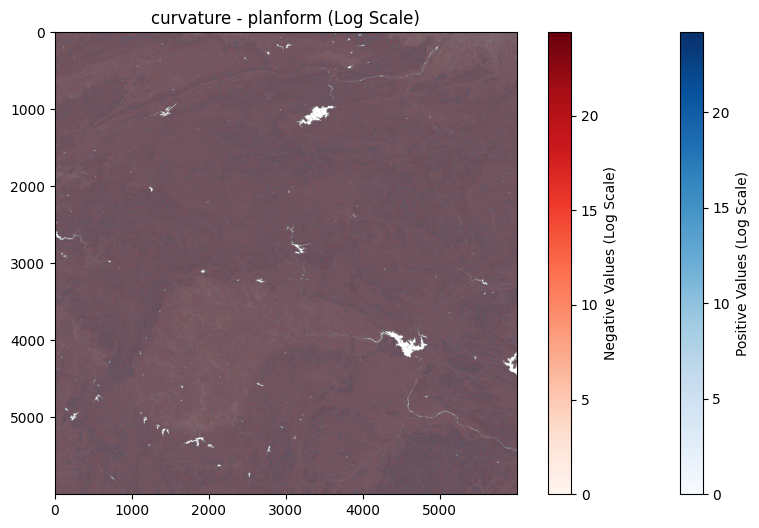

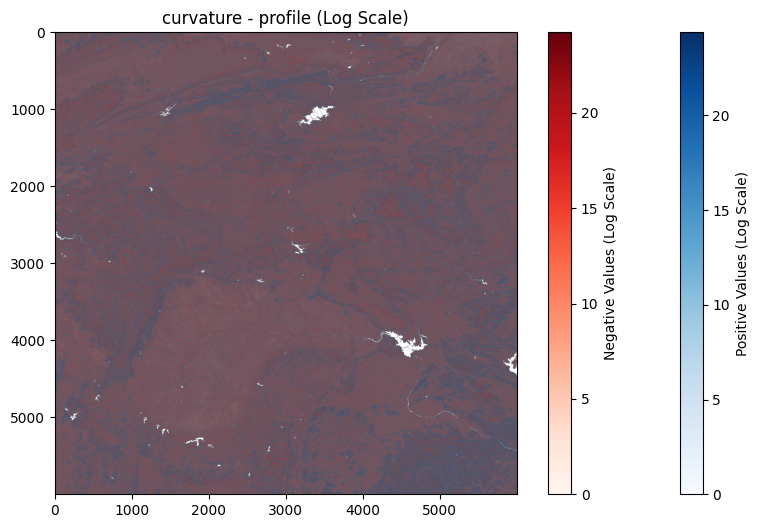

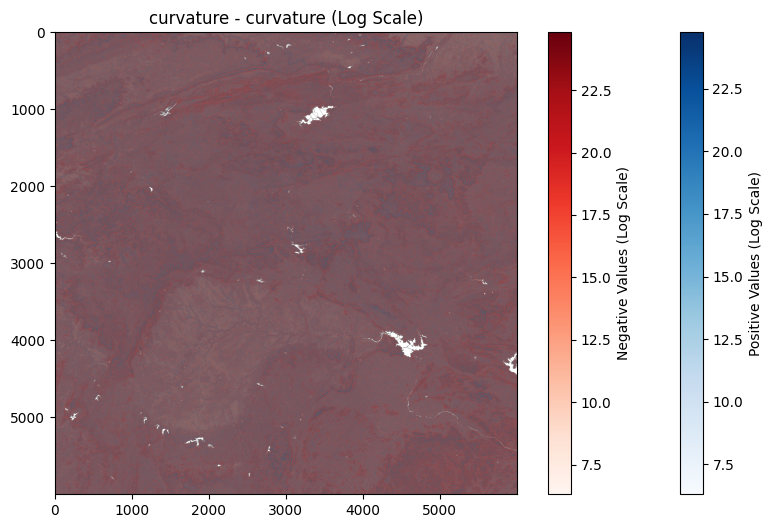

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_terrain_attributes(terrain_attributes):
    log_scale_attributes = ['slope_riserun', 'slope_percentage', 'aspect', 'curvature_planform', 'curvature_profile', 'curvature_curvature']
    
    for attribute, values in terrain_attributes.items():
        if isinstance(values, dict):
            for sub_attribute, sub_values in values.items():
                plt.figure(figsize=(10, 6))
                if f'{attribute}_{sub_attribute}' in log_scale_attributes:
                    if 'curvature' in attribute:
                        positive_values = np.where(sub_values > 0, sub_values, np.nan)
                        negative_values = np.where(sub_values < 0, sub_values, np.nan)
                        
                        plt.imshow(np.log1p(positive_values), cmap='Blues')  # log1p to avoid log(0)
                        plt.colorbar(label='Positive Values (Log Scale)', orientation='vertical')
                        
                        plt.imshow(np.log1p(-negative_values), cmap='Reds')  # log1p to avoid log(0)
                        plt.colorbar(label='Negative Values (Log Scale)', orientation='vertical')
                        
                        plt.title(f'{attribute} - {sub_attribute} (Log Scale)')
                    else:
                        plt.imshow(np.log1p(sub_values), cmap='Blues')  # log1p to avoid log(0)
                        plt.colorbar()
                        plt.title(f'{attribute} - {sub_attribute} (Log Scale)')
                else:
                    plt.imshow(sub_values, cmap='Blues')
                    plt.colorbar()
                    plt.title(f'{attribute} - {sub_attribute}')
                plt.show()
        else:
            plt.figure(figsize=(10, 6))
            if attribute in log_scale_attributes:
                plt.imshow(np.log1p(values), cmap='Blues')  # log1p to avoid log(0)
                plt.colorbar()
                plt.title(f'{attribute} (Log Scale)')
            else:
                plt.imshow(values, cmap='Blues')
                plt.colorbar()
                plt.title(attribute)
            plt.show()

plot_terrain_attributes(terrain_attributes)

In [7]:
import pandas as pd
# Flatten the terrain_attributes dictionary
flattened_data = {}
for attribute, values in terrain_attributes.items():
    if isinstance(values, dict):
        for sub_attribute, sub_values in values.items():
            flattened_data[f'{attribute}_{sub_attribute}'] = sub_values.flatten()
    else:
        flattened_data[attribute] = values.flatten()

# Convert the flattened data into a pandas DataFrame
terrain_df = pd.DataFrame(flattened_data)

# Print the description of the DataFrame
terrain_df.describe()

,slope_riserun,slope_percentage,slope_degrees,slope_radians,aspect,curvature_planform,curvature_profile,curvature_curvature
count,3.600000e+07,3.600000e+07,3.600000e+07,3.600000e+07,3.600000e+07,3.600000e+07,3.600000e+07,3.600000e+07
mean,6.023884e+03,6.023888e+05,8.951169e+01,1.562269e+00,1.798715e+02,5.744852e+07,5.739756e+07,6.098489e-02
std,9.164450e+03,9.164451e+05,6.289781e+00,1.097774e-01,1.052982e+02,8.673054e+08,9.550642e+08,1.561109e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.939635e+10,-3.290449e+10,-5.997601e+10
25%,1.241468e+03,1.241468e+05,8.995385e+01,1.569991e+00,8.895831e+01,-2.379612e+08,-2.335560e+08,-5.472115e+08
50%,2.666878e+03,2.666878e+05,8.997852e+01,1.570421e+00,1.797272e+02,6.061840e+06,2.806587e+07,-2.878418e+07
75%,5.968163e+03,5.968162e+05,8.999040e+01,1.570629e+00,2.700000e+02,2.947096e+08,3.402916e+08,4.752026e+08
max,1.544266e+05,1.544266e+07,8.999963e+01,1.570790e+00,3.600000e+02,3.189404e+10,3.888000e+10,5.608799e+10


## Spatial Encodings

In [10]:
def process(idx, row):
    # lon: -180 to 180; lat: -60 to 90
    lon_transform = lambda x: np.sin(2 * np.pi * (x+180) / 360)
    lat_transform = lambda x: (x - (-60))/(90 - (-60))

    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)

    data = pd.DataFrame(columns = nodes_coords.index, index = ['lon_transformed', 'lat_transformed'])
    for node_idx, node_row in nodes_coords.iterrows():
        lat, lon = node_row['lat'], node_row['lon']
        data.loc['lon_transformed', node_idx] = lon_transform(lon)
        data.loc['lat_transformed', node_idx] = lat_transform(lat)

    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id), exist_ok = True)
    data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, f'spatial_encodings.csv'))

with Parallel(n_jobs = 8, verbose = 0) as parallel:
    _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:00<00:00, 110.13it/s]


## uparea

In [11]:
uparea = xr.open_dataset(os.path.join(PATHS['gis_ldd'], 'MERIT-Plus_15min/upstream_area_km2.nc'))
ds_varname = list(uparea.data_vars)[0]
uparea = uparea[ds_varname]
uparea = uparea.sel(
    lat = slice(region_bounds['maxy'], region_bounds['miny']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)
uparea.load()

def process(idx, row):
    huc, gauge_id = row['huc_02'], row.name
    nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)

    data = pd.DataFrame(columns = nodes_coords.index, index = [0])
    for node_idx, node_row in nodes_coords.iterrows():
        lat, lon = node_row['lat'], node_row['lon']
        data.loc[0, node_idx] = uparea.sel(lat = lat, lon = lon, method = 'nearest').values.item()

    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id), exist_ok = True)
    data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, f'uparea.csv'))

with Parallel(n_jobs = 8, verbose = 0) as parallel:
    _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

uparea.close()
del uparea
gc.collect()

100%|██████████| 61/61 [00:00<00:00, 87.74it/s]


49

## USGS

In [12]:
def process(idx, row):
    huc, gauge_id = row['huc_02'], row.name
    uparea = row['area_geospa_fabric']

    usgs_filepath = os.path.join(PATHS['USGS'], 'CAMELS-US', huc, 'csv', f'{gauge_id}.csv')
    usgs_data = pd.read_csv(usgs_filepath, index_col = 0, parse_dates = True)
    usgs_data.columns = ['Q_ft3s']
    usgs_data['Q_mm'] = ((usgs_data['Q_ft3s'] / (3.28084**3)) / (uparea * 1e6)) * (3600*24*1000)

    os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id), exist_ok = True)
    usgs_data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, f'USGS.csv'))

with Parallel(n_jobs = 8, verbose = 0) as parallel:
    _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

100%|██████████| 61/61 [00:00<00:00, 168.03it/s]


## GloFAS Parameter Maps

In [15]:
# "Catchment_morphology_and_river_network" (14 surface fields)
# - chanbnkf_Global_03min.nc (channel bankfull depth, m);
# - chanflpn_Global_03min.nc (width of the floodplain, m);
# - changrad_Global_03min.nc (channel longitudinal gradient, m/m);
# - chanlength_Global_03min.nc (channel length within a pixel, m);
# - chanman_Global_03min.nc (channel Manning's roughness coefficient, m^(1/3)s^(-1));
# - chans_Global_03min.nc (channel side slope, m/m);
# - chanbw_Global_03min.nc (channel bottom width, m):

# "Land_use" (7 surface fields)
# - fracforest_Global_03min.nc (fraction of forest for each grid-cell, -);
# - fracirrigated_Global_03min.nc (fraction of irrigated crops [except rice] for each grid-cell, -);
# - fracrice_Global_03min.nc (fraction of rice crops for each grid-cell, -);
# - fracsealed_Global_03min.nc (fraction of urban area for each grid-cell, -);
# - fracwater_Global_03min.nc (fraction of inland water for each grid-cell, -);
# - fracother_Global_03min.nc (fraction of other land cover for each grid-cell, -);
Parameter_Maps = os.path.join(PATHS['GloFAS'], 'LISFLOOD_Parameter_Maps')

var_names = ['chanbnkf', 'chanflpn', 'changrad', 'chanlength', 'chanman', 'chans', 'chanbw']
for var_name in var_names:
    print(var_name)
    ds = xr.open_dataset(os.path.join(Parameter_Maps, 'Catchments_morphology_and_river_network', f"{var_name}_Global_03min.nc"))['Band1']
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    ds.load()

    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(columns = nodes_coords.index, index = [0])
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            # ds_window_loc = ds.sel(lat = lat, lon = lon, method = 'nearest')
            ds_window_loc = ds.sel(
                lat = slice(lat + 0.5*resolution, lat - 0.5*resolution),
                lon = slice(lon - 0.5*resolution, lon + 0.5*resolution)
            ).mean()
            data.loc[0, node_idx] = ds_window_loc.values.item()
        os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'static', 'GloFAS'), exist_ok = True)
        data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'static', 'GloFAS', f"{var_name}.csv"))

    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

    ds.close()
    del ds
    gc.collect()

var_names = ['fracforest', 'fracirrigated', 'fracrice', 'fracsealed', 'fracwater', 'fracother']
for var_name in var_names:
    print(var_name)
    ds = xr.open_dataset(os.path.join(Parameter_Maps, 'Land_use', f"{var_name}_Global_03min.nc"))['Band1']
    ds = ds.sel(
        lat = slice(region_bounds['maxy'], region_bounds['miny']), 
        lon = slice(region_bounds['minx'], region_bounds['maxx'])
    )
    ds.load()

    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(columns = nodes_coords.index, index = [0])
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            # ds_window_loc = ds.sel(lat = lat, lon = lon, method = 'nearest')
            ds_window_loc = ds.sel(
                lat = slice(lat + 0.5*resolution, lat - 0.5*resolution),
                lon = slice(lon - 0.5*resolution, lon + 0.5*resolution)
            ).mean()
            data.loc[0, node_idx] = ds_window_loc.values.item()
        os.makedirs(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'static', 'GloFAS'), exist_ok = True)
        data.to_csv(os.path.join(PATHS['devp_datasets'], DIRNAME, 'graph_features', huc, gauge_id, 'static', 'GloFAS', f"{var_name}.csv"))

    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph)))

chanbnkf


100%|██████████| 61/61 [00:00<00:00, 92.26it/s]


chanflpn


100%|██████████| 61/61 [00:00<00:00, 621.20it/s]


changrad


100%|██████████| 61/61 [00:00<00:00, 443.59it/s]


chanlength


100%|██████████| 61/61 [00:00<00:00, 462.19it/s]


chanman


100%|██████████| 61/61 [00:00<00:00, 403.34it/s]


chans


100%|██████████| 61/61 [00:00<00:00, 387.24it/s]


chanbw


100%|██████████| 61/61 [00:00<00:00, 414.64it/s]


fracforest


100%|██████████| 61/61 [00:00<00:00, 393.46it/s]


fracirrigated


100%|██████████| 61/61 [00:00<00:00, 385.38it/s]


fracrice


100%|██████████| 61/61 [00:00<00:00, 382.17it/s]


fracsealed


100%|██████████| 61/61 [00:00<00:00, 380.43it/s]


fracwater


100%|██████████| 61/61 [00:00<00:00, 381.28it/s]


fracother


100%|██████████| 61/61 [00:00<00:00, 365.21it/s]
